<a href="https://www.kaggle.com/code/mikedelong/us-state-literacy-versus-population?scriptVersionId=140901947" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
df = pd.read_csv(filepath_or_buffer='/kaggle/input/us-state-literacy-and-population-estimates-in-2017/LITERACY_AND_POP_V2.csv', index_col='State')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, New Hampshire to New Mexico
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Lit_A    51 non-null     float64
 1   POP_EST  51 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 1.2+ KB


In [2]:
from plotly.express import scatter
scatter(data_frame=df.reset_index(), x='POP_EST', y='Lit_A', hover_name='State', log_x=True, color='Lit_A')

It would appear the states with the larger populations (California, Texas, Florida, and New York) are all below the national average score of 264. 

There could be many factors for this. What is worth noting here is the literacy rate of Minnesota (278.8, population 5.5 million) is second highest, and the literacy rate of Louisiana (251.5, population 4.6 million) is second lowest. 

So, while population seems to be correlated to the ability of a state to increase literacy rates, there must be something unique to either Minnesota or Louisana to explain why they are so far away from the mean despite similar populations.

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning:

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



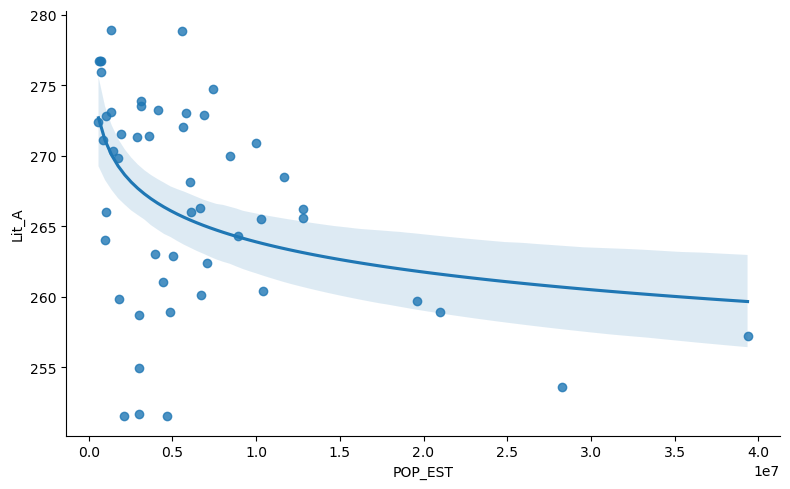

In [3]:
from seaborn import lmplot
lmplot(data=df, x='POP_EST', y='Lit_A', legend=True, logx=True, aspect=1.6)

Yeah the linear model tells us population is negatively correlated with literacy rate.

In [4]:
from sklearn.metrics import r2_score

r2_score(df['POP_EST'], df['Lit_A'])

-0.7795705958398502

Let's add in the state abbreviations as we're SURE to need them eventually.

In [5]:
states_df = pd.read_csv(filepath_or_buffer='https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv')
states_df.head()

,State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


And just for giggles let's replot the graph above but color according to the 2016 election results. I transcribed these by hand so they're probably a little off.

In [6]:
# https://en.wikipedia.org/wiki/2016_United_States_presidential_election#Results_by_state
Presidential_2016_result = {'Alabama': 'R',
 'Alaska': 'R',
 'Arizona': 'R',
 'California': 'D',
 'Colorado': 'D',
 'Connecticut': 'D',
 'Delaware': 'D',
 'District of Columbia': 'D',
 'Florida': 'R',
 'Georgia': 'R',
 'Hawaii': 'D',
 'New Hampshire': 'D',
 'Minnesota': 'D',
 'Vermont': 'D',
 'North Dakota': 'R',
 'Washington': 'D',
 'Utah': 'R',
 'Iowa': 'R',
 'Oregon': 'D',
 'Maine': 'D',
 'Wisconsin': 'R',
 'Massachusetts': 'D',
 'Montana': 'R',
 'Wyoming': 'R',
 'Nebraska': 'R',
 'Kansas': 'R',
 'South Dakota': 'R',
 'Michigan': 'R',
 'Virginia': 'D',
 'Idaho': 'R',
 'Ohio': 'R',
 'Maryland': 'D',
 'Indiana': 'R',
 'Pennsylvania': 'R',
 'Missouri': 'R',
 'Rhode Island': 'D',
 'Illinois': 'D',
 'North Carolina': 'R',
 'New Jersey': 'D',
 'Oklahoma': 'R',
 'South Carolina': 'R',
 'Kentucky': 'R',
 'Tennessee': 'R',
 'West Virginia': 'R',
 'New York': 'D',
 'Arkansas': 'R',
 'Nevada': 'D',
 'Texas': 'R',
 'Mississippi': 'R',
 'Louisiana': 'R',
 'New Mexico': 'D'}

election_df = pd.DataFrame(data={'State': list(Presidential_2016_result.keys()),
                                 'result_2016': list(Presidential_2016_result.values())})
election_df.head()

,State,result_2016
0,Alabama,R
1,Alaska,R
2,Arizona,R
3,California,D
4,Colorado,D


In [7]:
df = df.reset_index().merge(right=states_df, on='State').merge(right=election_df, on='State')
df['weighted'] = df['Lit_A'] * df['POP_EST']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 50
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   State         51 non-null     object 
 1   Lit_A         51 non-null     float64
 2   POP_EST       51 non-null     int64  
 3   Abbreviation  51 non-null     object 
 4   result_2016   51 non-null     object 
 5   weighted      51 non-null     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 2.8+ KB


In [8]:
scatter(data_frame=df, x='POP_EST', y='Lit_A', hover_name='State', log_x=True, color='result_2016')

In [9]:
for result in df['result_2016'].unique():
    result_df = df[df['result_2016'] == result]
    print('{} mean: {} median: {} weighted mean: {}'.format(result, 
                                          round(result_df['Lit_A'].mean(), 1),
                                          result_df['Lit_A'].median(),
                                          round(result_df['weighted'].mean()/result_df['POP_EST'].mean(), 1)
                                         ))

D mean: 268.6 median: 270.3 weighted mean: 264.6
R mean: 265.6 median: 266.1 weighted mean: 262.6


There's a 1-2% D/R difference regardless of how we measure it.

Literacy is supposed to correlate with wealth/income. Let's get some data and take a look.

In [10]:
# https://www.epi.org/blog/household-incomes-in-2017-stayed-on-existing-trends-in-most-states-incomes-in-21-states-are-still-below-their-pre-recession-levels/
income_dict = {'Alabama': 48123,
 'Alaska': 73181,
 'Arizona': 56581,
 'Arkansas': 45869,
 'California': 71805,
 'Colorado': 69117,
 'Connecticut': 74168,
 'Delaware': 62852,
 'Florida': 52594,
 'Georgia': 56183,
 'Hawaii': 77765,
 'Idaho': 52225,
 'Illinois': 62992,
 'Indiana': 54181,
 'Iowa': 58570,
 'Kansas': 56422,
 'Kentucky': 48375,
 'Louisiana': 46145,
 'Maine': 56277,
 'Maryland': 80776,
 'Massachusetts': 77385,
 'Michigan': 54909,
 'Minnesota': 68388,
 'Mississippi': 43529,
 'Missouri': 53578,
 'Montana': 53386,
 'Nebraska': 59970,
 'Nevada': 58003,
 'New Hampshire': 73381,
 'New Jersey': 80088,
 'New Mexico': 46744,
 'New York': 64894,
 'North Carolina': 52752,
 'North Dakota': 61843,
 'Ohio': 54021,
 'Oklahoma': 50051,
 'Oregon': 60212,
 'Pennsylvania': 59195,
 'Rhode Island': 63870,
 'South Carolina': 50570,
 'South Dakota': 56521,
 'Tennessee': 51340,
 'Texas': 59206,
 'Utah': 68358,
 'Vermont': 57513,
 'Virginia': 71535,
 'Washington': 70979,
 'District of Columbia': 82372,
 'West Virginia': 43469,
 'Wisconsin': 59305,
 'Wyoming': 60434}
df = df.merge(right=pd.DataFrame(data={'State': list(income_dict.keys()), 'Income': list(income_dict.values())}), on='State')
df.head()

,State,Lit_A,POP_EST,Abbreviation,result_2016,weighted,Income
0,New Hampshire,278.9,1348787,NH,D,3.761767e+08,73381
1,Minnesota,278.8,5566230,MN,D,1.551865e+09,68388
2,Alaska,276.7,739700,AK,R,2.046750e+08,73181
3,District of Columbia,276.7,694906,DC,D,1.922805e+08,82372
4,Vermont,276.7,624344,VT,D,1.727560e+08,57513


In [11]:
scatter(data_frame=df, x='Income', y='Lit_A', hover_name='State', log_x=False, color='POP_EST')

If we squint we can sort of see the sort of linear relationship between median household income and literacy (2017). The color isn't doing us much good here because state population is heavily skewed.

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



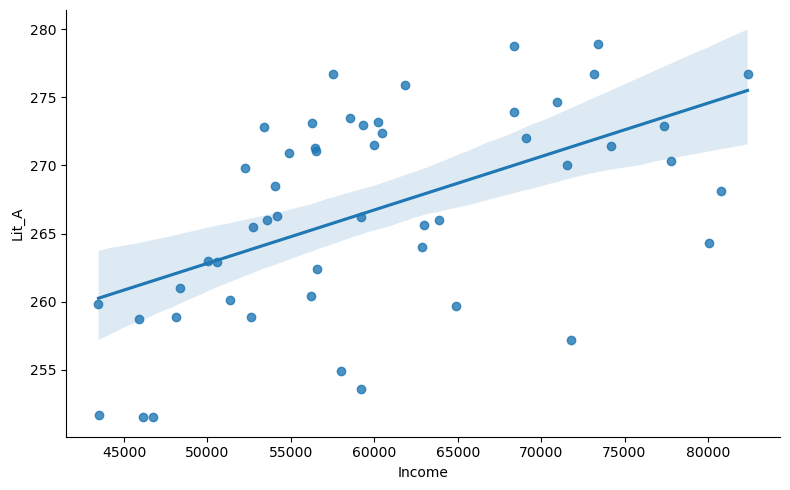

In [12]:
lmplot(data=df, x='Income', y='Lit_A', legend=True, logx=False, aspect=1.6)

The LM plot makes the trendline explicit and we can at least see that the slope of the trendline is positive; that's something, isn't it?

In [13]:
scatter(data_frame=df, x='Income', y='Lit_A', hover_name='State', log_x=False, color='result_2016', trendline='ols', trendline_scope='overall')

This plot is interesting in two ways: first because of how the D and R states are mostly separated along income lines, but also how, weirdly, how most D states are below the trendline. Probably best not to read too much into this.